Epoch 0 | Total: 86.547859 | Data: 86.547310 | PDE: 0.000547
Epoch 200 | Total: 11.749704 | Data: 11.307065 | PDE: 0.442640
Epoch 400 | Total: 2.429046 | Data: 1.942140 | PDE: 0.486905
Epoch 600 | Total: 1.112242 | Data: 0.810818 | PDE: 0.301423
Epoch 800 | Total: 0.630259 | Data: 0.560982 | PDE: 0.069276
Epoch 1000 | Total: 0.462533 | Data: 0.419886 | PDE: 0.042648
Epoch 1200 | Total: 0.375555 | Data: 0.343222 | PDE: 0.032334
Epoch 1400 | Total: 0.312235 | Data: 0.301063 | PDE: 0.011172
Epoch 1600 | Total: 0.290831 | Data: 0.277624 | PDE: 0.013206
Epoch 1800 | Total: 0.275085 | Data: 0.266224 | PDE: 0.008862


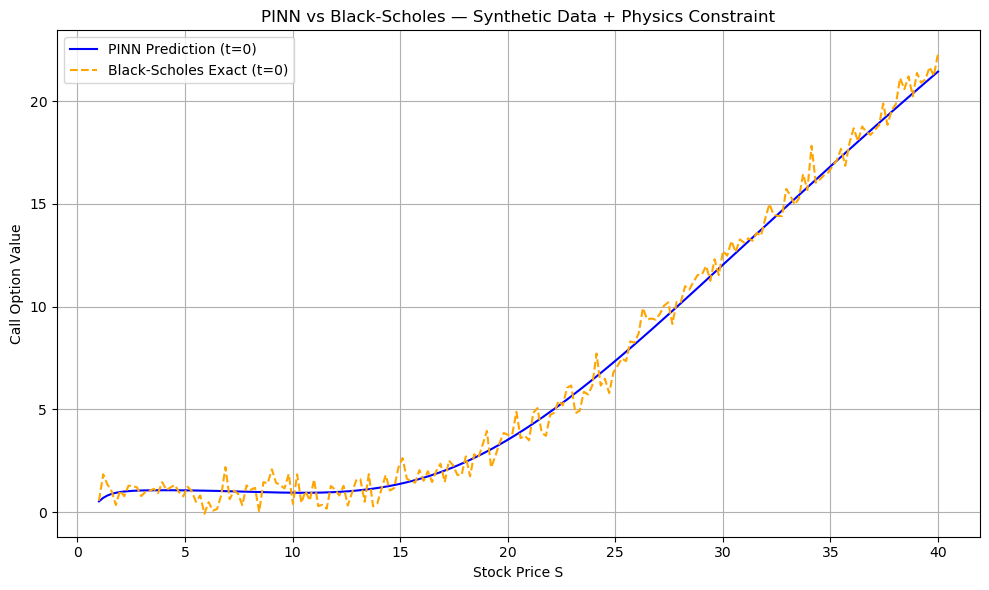

In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from utils import * 


# Parameters
K = 20
T = 1.0
r = 0.05
sigma = 0.25
N_data = 3000
min_S = 1
max_S = 40

# Create synthetic dataset
S_data = np.random.uniform(1, 40, (N_data, 1))
t_data = np.random.uniform(0, T, (N_data, 1))
C_exact = black_scholes_solution(S_data, K, T - t_data, r, sigma)
C_data = C_exact + np.random.normal(0, 0.5, size=C_exact.shape) + 1.0  # add noise 

# Convert to torch tensors
S_data_torch = torch.tensor(S_data, dtype=torch.float32, requires_grad=True)
t_data_torch = torch.tensor(t_data, dtype=torch.float32, requires_grad=True)
C_data_torch = torch.tensor(C_data, dtype=torch.float32)

# PINN model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, S, t):
        return self.net(torch.cat([S, t], dim=1))

model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# PDE loss: Black-Scholes residual
def pde_residual(S, t):
    C = model(S, t)
    dC_dt = autograd.grad(C, t, grad_outputs=torch.ones_like(C), create_graph=True, retain_graph=True)[0]
    dC_dS = autograd.grad(C, S, grad_outputs=torch.ones_like(C), create_graph=True, retain_graph=True)[0]
    d2C_dS2 = autograd.grad(dC_dS, S, grad_outputs=torch.ones_like(C), create_graph=True, retain_graph=True)[0]
    res = dC_dt + 0.5 * sigma**2 * S**2 * d2C_dS2 + r * S * dC_dS - r * C
    return res

# Training
for epoch in range(2000):
    optimizer.zero_grad()

    # Data loss (fit noisy synthetic data)
    C_pred_data = model(S_data_torch, t_data_torch)
    loss_data = torch.mean((C_pred_data - C_data_torch) ** 2)

    # PDE loss (collocation points)
    S_colloc = torch.tensor(np.random.uniform(1, 40, (1000, 1)), dtype=torch.float32, requires_grad=True)
    t_colloc = torch.tensor(np.random.uniform(0, T, (1000, 1)), dtype=torch.float32, requires_grad=True)
    pde = pde_residual(S_colloc, t_colloc)
    loss_pde = torch.mean(pde ** 2)

    # Total loss
    loss = loss_data + loss_pde
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch} | Total: {loss.item():.6f} | Data: {loss_data.item():.6f} | PDE: {loss_pde.item():.6f}")

# Evaluate at t = 0
S_eval = torch.linspace(1, 40, 200).view(-1, 1)
t_eval = torch.zeros_like(S_eval)
with torch.no_grad():
    C_pred = model(S_eval, t_eval).numpy()

# Ground truth Black-Scholes at t=0
S_np = S_eval.numpy().flatten()
C_true = black_scholes_solution(S_np, K, T, r, sigma) + 1
C_true += np.random.normal(0, 0.5, size=C_true.shape)
# Plot result
plt.figure(figsize=(10, 6))
plt.plot(S_np, C_pred, label="PINN Prediction (t=0)", color='blue')
plt.plot(S_np, C_true, '--', label="Black-Scholes Exact (t=0)", color='orange')
plt.xlabel("Stock Price S")
plt.ylabel("Call Option Value")
plt.title("PINN vs Black-Scholes — Synthetic Data + Physics Constraint")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()